In [1]:
%run init_notebookspace.py

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [4]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.api as sm

# from pymc.sampling_jax import sample_blackjax_nuts

In [5]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [6]:
def simulate_var(
    intercepts, coefs_yy, coefs_xy, coefs_xx, coefs_yx, noises=(1, 1), *, warmup=100, steps=200
):
    draws_y = np.zeros(warmup + steps)
    draws_x = np.zeros(warmup + steps)
    draws_y[:2] = intercepts[0]
    draws_x[:2] = intercepts[1]
    for step in range(2, warmup + steps):
        draws_y[step] = (
            intercepts[0]
            + coefs_yy[0] * draws_y[step - 1]
            + coefs_yy[1] * draws_y[step - 2]
            + coefs_xy[0] * draws_x[step - 1]
            + coefs_xy[1] * draws_x[step - 2]
            + rng.normal(0, noises[0])
        )
        draws_x[step] = (
            intercepts[1]
            + coefs_xx[0] * draws_x[step - 1]
            + coefs_xx[1] * draws_x[step - 2]
            + coefs_yx[0] * draws_y[step - 1]
            + coefs_yx[1] * draws_y[step - 2]
            + rng.normal(0, noises[1])
        )
    return draws_y[warmup:], draws_x[warmup:]

In [11]:
var_y, var_x = simulate_var(
    intercepts=(18, 8),
    coefs_yy=(-0.8, 0),
    coefs_xy=(0.9, 0),
    coefs_xx=(1.3, -0.7),
    coefs_yx=(-0.1, 0.3),
)

df = pd.DataFrame({"x": var_x, "y": var_y})
df.head()

,x,y
0,34.375363,26.242117
1,33.418668,26.566967
2,32.688611,25.984243
3,30.935011,26.620612
4,31.179465,24.613329


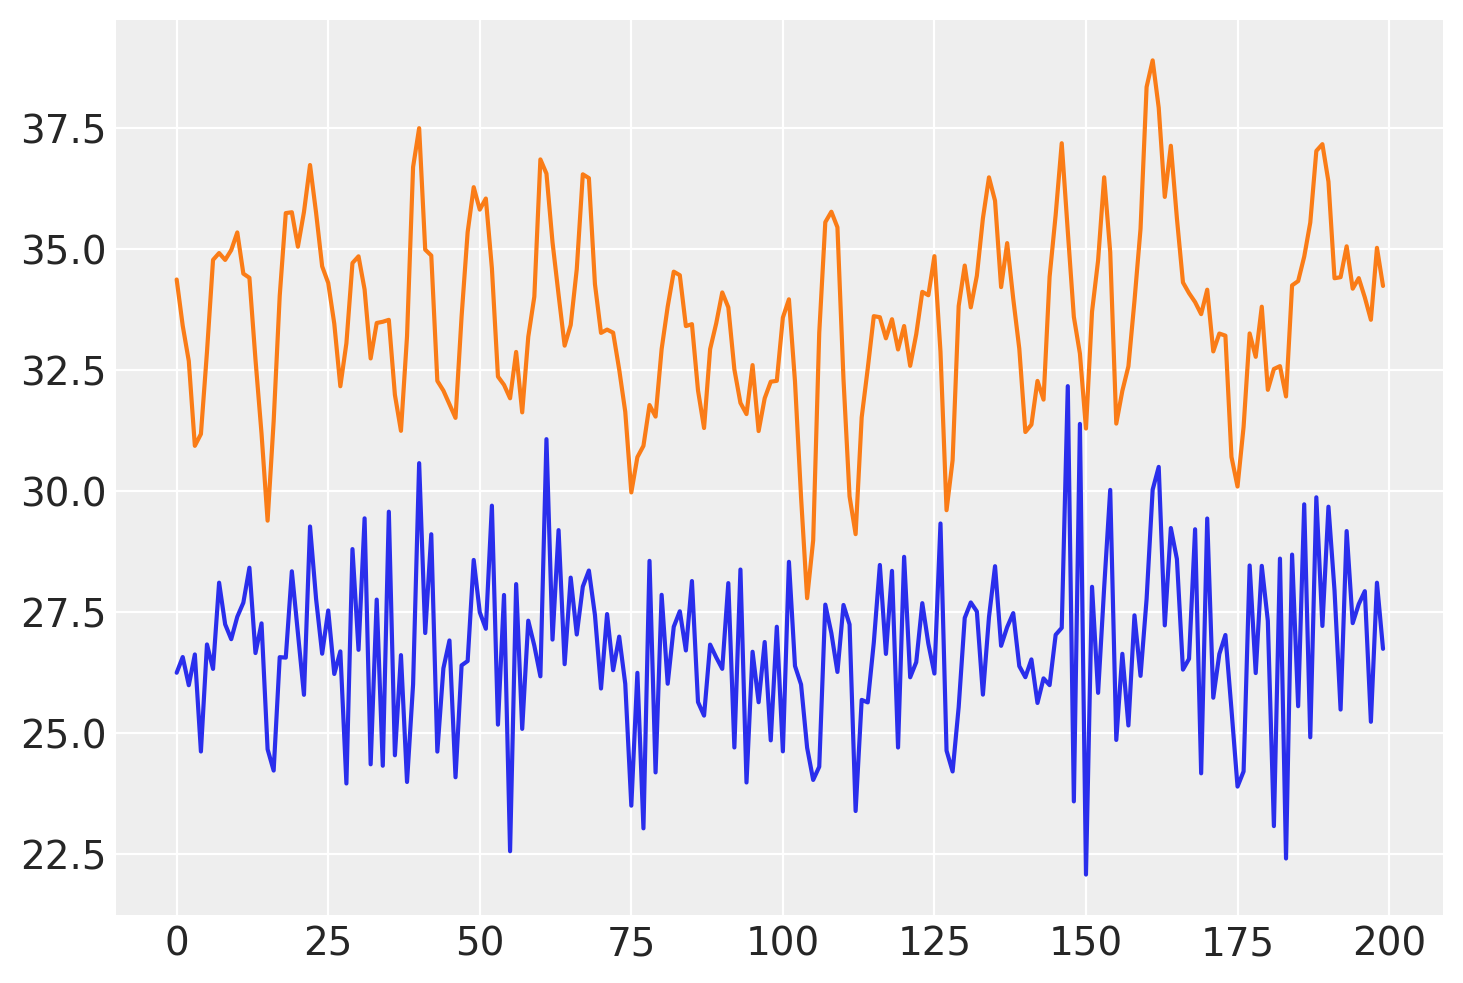

In [12]:
plt.plot(var_y)
plt.plot(var_x)

In [14]:
### Define a helper function that will construct our autoregressive step for the marginal contribution of each lagged
### term in each of the respective time series equations
def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    ars = []
    for j in range(n_eqs):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        ars.append(ar)
    beta = pm.math.stack(ars, axis=-1)

    return beta


### Make the model in such a way that it can handle different specifications of the likelihood term
### and can be run for simple prior predictive checks. This latter functionality is important for debugging of
### shape handling issues. Building a VAR model involves quite a few moving parts and it is handy to
### inspect the shape implied in the prior predictive checks.
def make_model(n_lags, n_eqs, df, priors, mv_norm=True, prior_checks=True):
    coords = {
        "lags": np.arange(n_lags) + 1,
        "equations": df.columns.tolist(),
        "cross_vars": df.columns.tolist(),
        "time": [x for x in df.index[n_lags:]],
    }

    with pm.Model(coords=coords) as model:
        lag_coefs = pm.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )
        alpha = pm.Normal(
            "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
        )
        data_obs = pm.Data("data_obs", df.values[n_lags:], dims=["time", "equations"], mutable=True)

        betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
        betaX = pm.Deterministic(
            "betaX",
            betaX,
            dims=[
                "time",
            ],
        )
        mean = alpha + betaX

        if mv_norm:
            n = df.shape[1]
            ## Under the hood the LKJ prior will retain the correlation matrix too.
            noise_chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n,
                sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
            )
            obs = pm.MvNormal(
                "obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"]
            )
        else:
            ## This is an alternative likelihood that can recover sensible estimates of the coefficients
            ## But lacks the multivariate correlation between the timeseries.
            sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
            obs = pm.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs, dims=["time", "equations"]
            )

        if prior_checks:
            idata = pm.sample_prior_predictive()
            return model, idata
        else:
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(draws=2000, random_seed=130))
            pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)
    return model, idata

In [15]:
n_lags = 2
n_eqs = 2
priors = {
    "lag_coefs": {"mu": 0.3, "sigma": 1},
    "alpha": {"mu": 15, "sigma": 5},
    "noise_chol": {"eta": 1, "sigma": 1},
    "noise": {"sigma": 1},
}

model, idata = make_model(n_lags, n_eqs, df, priors)
# pm.model_to_graphviz(model)

Sampling: [alpha, lag_coefs, noise_chol, obs]


ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

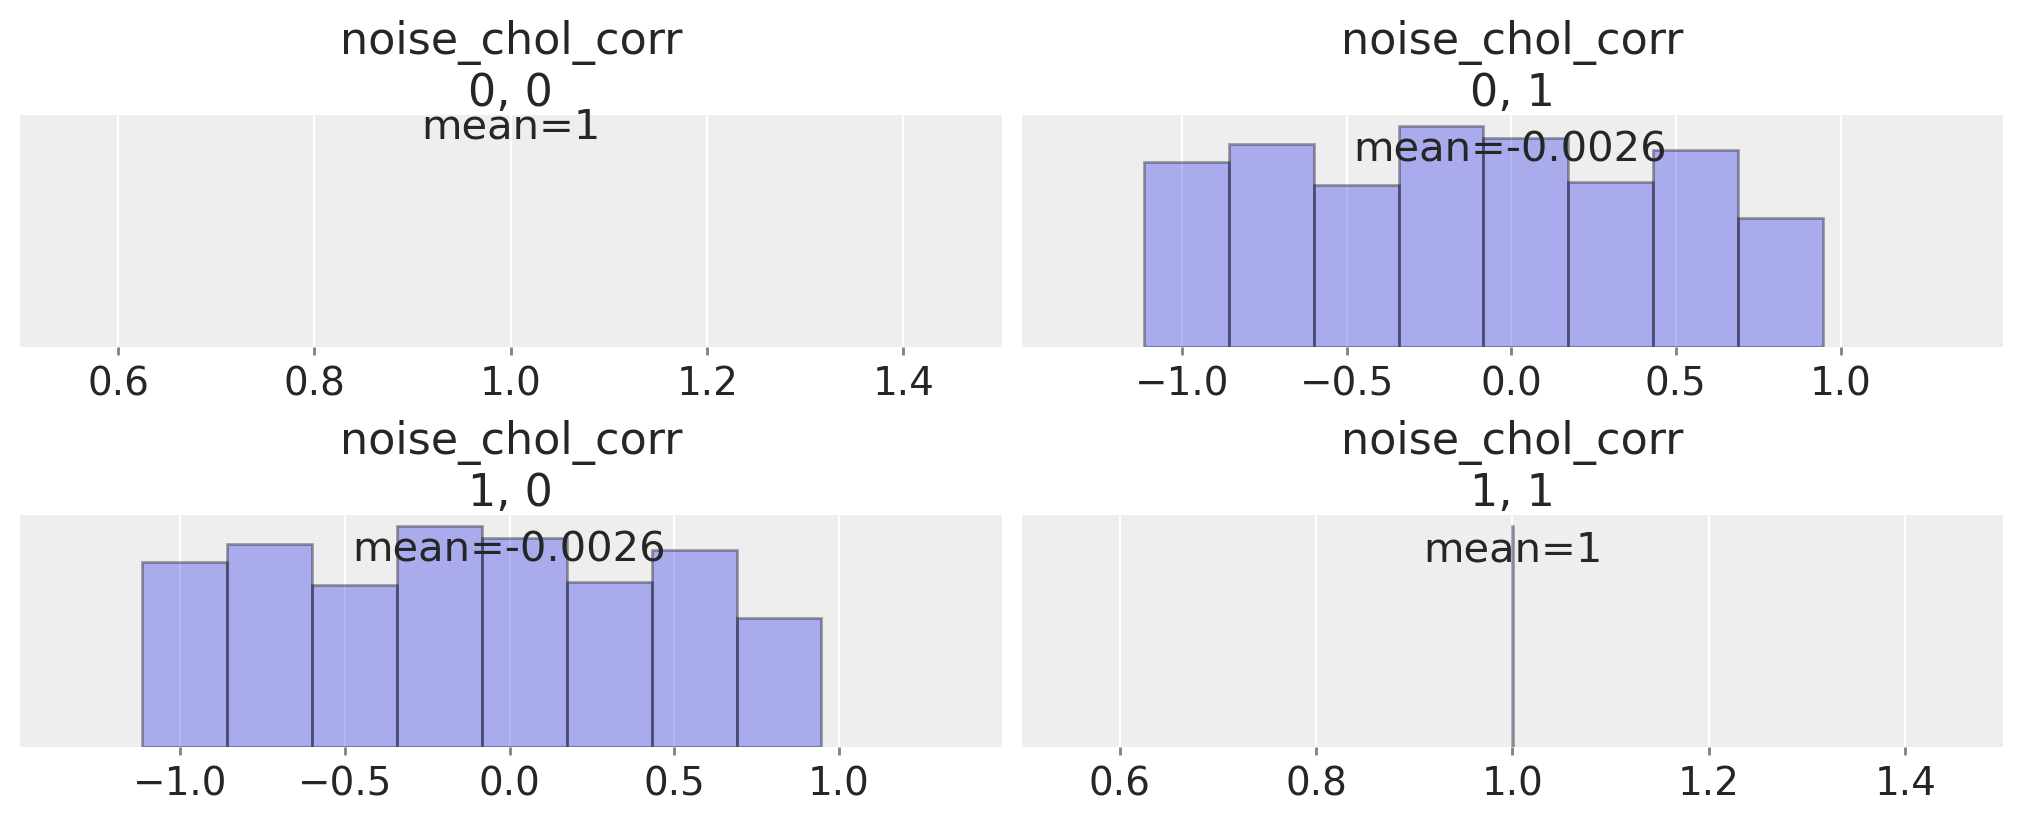

In [16]:
ax = az.plot_posterior(
    idata,
    var_names="noise_chol_corr",
    hdi_prob="hide",
    group="prior",
    point_estimate="mean",
    grid=(2, 2),
    kind="hist",
    ec="black",
    figsize=(10, 4),
)

In [18]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [17]:
n_lags = 2
n_eqs = 2
model, idata_fake_data = make_model(n_lags, n_eqs, df, priors, prior_checks=False)

Sampling: [alpha, lag_coefs, noise_chol, obs]

KeyboardInterrupt

